In [ ]:
import pandas as pd
from shapely.geometry import Polygon, Point, LineString
import folium
import random
import googlemaps
import json

# GOOGLE_MAPS_API_KEY: API key for Google Maps
with open('config.json', 'r') as config_file:
    config = json.load(config_file)
GOOGLE_MAPS_API_KEY = config['GOOGLE_MAPS_API_KEY']

# DEBRECEN_POLYGON_MAP_COORDINATES_PATH: CSV file path containing Debrecen polygon coordinates
DEBRECEN_POLYGON_MAP_COORDINATES_PATH = 'coordinates/debrecen_coordinates_v1.csv'

# NO_FLY_ZONE_COORDINATES_PATHS: List of CSV file paths for no-fly zone coordinates (airport, clinics, etc.)
NO_FLY_ZONE_COORDINATES_PATHS = [
    'coordinates/airport_coordinates_v2.csv',
    'coordinates/clinics_coordinates_v1.csv',
    'coordinates/kenezi_coordinates_v1.csv',
    'coordinates/military_coordinates_v1.csv',
    'coordinates/railwaystation_coordinates_v2.csv',
    'coordinates/kassai_campus_coordinates_v1.csv',
    'coordinates/centrum_coordinates_v1.csv',
    'coordinates/ic_line_1_coordinates_v1.csv',
    'coordinates/ic_line_2_coordinates_v1.csv',
    'coordinates/ic_line_3_coordinates_v1.csv',
    'coordinates/ic_line_4_coordinates_v1.csv',
    'coordinates/stadium_coordinates_v1.csv'
]

# NUMBER_OF_SIMULATED_ORDERS: Number of random orders to simulate
NUMBER_OF_SIMULATED_ORDERS = 4000

# FORUM_COORDINATE_X and FORUM_COORDINATE_Y: Coordinates for Fórum Debrecen
FORUM_COORDINATE_X = 47.5326511
FORUM_COORDINATE_Y = 21.6287677

# PLOT_ROUTES_ON_MAP: Flag to enable plotting of routes on the map
PLOT_ROUTES_ON_MAP = False

# Load Debrecen polygon coordinates
data = pd.read_csv(DEBRECEN_POLYGON_MAP_COORDINATES_PATH)
coordinates = list(zip(data['Latitude'], data['Longitude']))
debrecen_polygon = Polygon(coordinates)

# Load no-fly zones as polygons
no_fly_zones = []
for path in NO_FLY_ZONE_COORDINATES_PATHS:
    no_fly_data = pd.read_csv(path)
    no_fly_coordinates = list(zip(no_fly_data['Latitude'], no_fly_data['Longitude']))
    no_fly_zones.append(Polygon(no_fly_coordinates))

# Generate the base map centered on Debrecen
center_lat = data['Latitude'].mean()
center_lon = data['Longitude'].mean()
map_debrecen = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Add Debrecen polygon to the map
folium.Polygon(
    locations=coordinates,
    color='blue',
    fill=True,
    fill_color='lightblue',
    fill_opacity=0.5,
    weight=2
).add_to(map_debrecen)

# Add no-fly zones to the map
for no_fly_zone in no_fly_zones:
    folium.Polygon(
        locations=list(no_fly_zone.exterior.coords),
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.5,
        weight=2
    ).add_to(map_debrecen)

# Generate random points inside the Debrecen polygon excluding no-fly zones
min_x, min_y, max_x, max_y = debrecen_polygon.bounds
random_points_inside_polygon = []

while len(random_points_inside_polygon) < NUMBER_OF_SIMULATED_ORDERS:
    random_point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
    if debrecen_polygon.contains(random_point) and not any(zone.contains(random_point) for zone in no_fly_zones):
        random_points_inside_polygon.append((random_point.x, random_point.y))

# Add random order points to the map
for point in random_points_inside_polygon:
    folium.CircleMarker(
        location=point,
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
    ).add_to(map_debrecen)

# Mark Fórum Debrecen on the map
forum_point = Point(FORUM_COORDINATE_X, FORUM_COORDINATE_Y)
forum_point_data = (forum_point.x, forum_point.y)
folium.CircleMarker(
    location=forum_point_data,
    radius=8,
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.9,
).add_to(map_debrecen)

# Initialize Google Maps API client
gmaps = googlemaps.Client(key=GOOGLE_MAPS_API_KEY)

# Calculate routes and durations for each destination using various transportation modes
results = []
for idx, destination in enumerate(random_points_inside_polygon):
    modes = ['driving', 'walking', 'bicycling']
    route_info = {'Destination': idx + 1, 'Coordinates': destination}
    
    for mode in modes:
        directions = gmaps.directions(
            origin=forum_point_data,
            destination=destination,
            mode=mode
        )
        
        if directions:
            leg = directions[0]["legs"][0]
            duration_minutes = leg["duration"]["value"] / 60.0
            distance_km = leg["distance"]["value"] / 1000.0
            route_info[f'{mode}_duration'] = duration_minutes
            route_info[f'{mode}_distance'] = distance_km
        else:
            route_info[f'{mode}_duration'] = None
            route_info[f'{mode}_distance'] = None
    
    results.append(route_info)

# Plot driving routes on the map if enabled
if PLOT_ROUTES_ON_MAP:
    map_plot = folium.Map(location=[FORUM_COORDINATE_X, FORUM_COORDINATE_Y], zoom_start=13)
    
    # Add Fórum Debrecen marker as the start point
    folium.Marker(location=forum_point_data, popup="Start Point", icon=folium.Icon(color="blue")).add_to(map_plot)
    
    # Add destination markers and driving routes for each order
    for result in results:
        folium.Marker(
            location=result['Coordinates'],
            popup=f"Destination {result['Destination']}",
            icon=folium.Icon(color="red")
        ).add_to(map_plot)
        
        directions = gmaps.directions(
            origin=forum_point_data,
            destination=result['Coordinates'],
            mode='driving'
        )
        
        if directions:
            steps = directions[0]['legs'][0]['steps']
            route_coordinates = [(step['start_location']['lat'], step['start_location']['lng']) for step in steps]
            route_coordinates.append(result['Coordinates'])
            folium.PolyLine(route_coordinates, color='green', weight=2.5, opacity=0.8).add_to(map_plot)
    
    map_plot.save("driving_routes_map.html")

# Save results to a DataFrame for further analysis
results_df = pd.DataFrame(results)

# Optionally, save results and maps to files
# results_df.to_csv("delivery_data.csv", sep=";")
# map_debrecen.save("delivery_data_map.html")

In [8]:
def calculate_length(coords):
    """
    Calculate the length of a LineString constructed from a list of (latitude, longitude) tuples.
    """
    return LineString(coords).length

def get_detour_route(zone, entry, exit):
    """
    Computes a detour route along the boundary of a given polygon (zone) between the specified entry and exit points.
    It inserts the entry and exit points into the polygon's boundary if needed and returns the shorter of the two possible paths.
    """
    coords = list(zone.exterior.coords)
    
    def insert_point(coords, pt):
        """
        Inserts point 'pt' into the coordinate list if it lies on the segment between two consecutive points.
        """
        new_coords = []
        for i in range(len(coords) - 1):
            seg = LineString([coords[i], coords[i+1]])
            if seg.distance(pt) < 1e-8:
                new_coords.append(coords[i])
                if (pt.x, pt.y) != coords[i]:
                    new_coords.append((pt.x, pt.y))
            else:
                new_coords.append(coords[i])
        new_coords.append(coords[-1])
        if (pt.x, pt.y) not in new_coords:
            new_coords.append((pt.x, pt.y))
        return new_coords

    # Insert entry and exit points into the polygon boundary if necessary.
    new_coords = insert_point(coords, entry)
    new_coords = insert_point(new_coords, exit)
    
    try:
        idx_entry = new_coords.index((entry.x, entry.y))
    except ValueError:
        idx_entry = 0
    try:
        idx_exit = new_coords.index((exit.x, exit.y))
    except ValueError:
        idx_exit = 0
    
    if idx_entry <= idx_exit:
        candidate1 = new_coords[idx_entry:idx_exit+1]
    else:
        candidate1 = new_coords[idx_entry:] + new_coords[:idx_exit+1]
    
    if idx_exit <= idx_entry:
        candidate2 = new_coords[idx_exit:idx_entry+1]
    else:
        candidate2 = new_coords[idx_exit:] + new_coords[:idx_entry+1]
    
    candidate1_line = LineString(candidate1)
    candidate2_line = LineString(candidate2)
    
    return candidate1 if candidate1_line.length <= candidate2_line.length else candidate2

def remove_duplicate_coords(route):
    """
    Removes consecutive duplicate coordinates from a route.
    If a coordinate is identical to the previous one, it will be skipped.
    """
    if not route:
        return route
    cleaned_route = [route[0]]
    for coord in route[1:]:
        if coord != cleaned_route[-1]:
            cleaned_route.append(coord)
    return cleaned_route

def compute_safe_route(start, end, zones):
    """
    Computes a safe route from a starting point to an ending point that avoids crossing any no-fly zones.
    It identifies intersections between the direct path and zone boundaries, calculates detour paths along those boundaries,
    and recursively constructs a safe route.
    
    Returns:
            A list of (latitude, longitude) coordinate tuples forming the safe route.
    """
    start_pt = Point(start)
    end_pt = Point(end)
    direct_line = LineString([start, end])
    
    intersections = []
    for zone in zones:
        if direct_line.intersects(zone):
            inter_geom = direct_line.intersection(zone.boundary)
            if inter_geom.is_empty:
                continue
            if inter_geom.geom_type == 'Point':
                pts = [inter_geom]
            elif inter_geom.geom_type == 'MultiPoint':
                pts = list(inter_geom.geoms)
            else:
                pts = []
            if len(pts) < 2:
                continue
            pts = sorted(pts, key=lambda p: start_pt.distance(p))
            entry_pt = pts[0]
            exit_pt = pts[-1]
            intersections.append({
                'zone': zone,
                'entry': entry_pt,
                'exit': exit_pt,
                'distance': start_pt.distance(entry_pt)
            })
    
    if not intersections:
        return [start, end]
    
    intersections.sort(key=lambda x: x['distance'])
    route = []
    current_start = start
    
    for inter in intersections:
        zone = inter['zone']
        entry_pt = inter['entry']
        exit_pt = inter['exit']
        safe_before = compute_safe_route(current_start, (entry_pt.x, entry_pt.y), zones)
        route.extend(safe_before[:-1])
        
        detour_coords = get_detour_route(zone, entry_pt, exit_pt)
        normal_detour = detour_coords
        reversed_detour = list(reversed(detour_coords))
        
        cost_normal = Point((entry_pt.x, entry_pt.y)).distance(Point(normal_detour[0])) + \
                        Point(normal_detour[-1]).distance(Point((exit_pt.x, exit_pt.y)))
        cost_reversed = Point((entry_pt.x, entry_pt.y)).distance(Point(reversed_detour[0])) + \
                        Point(reversed_detour[-1]).distance(Point((exit_pt.x, exit_pt.y)))
        
        chosen_detour = reversed_detour if cost_reversed < cost_normal else normal_detour
        route.extend(chosen_detour)
        current_start = (exit_pt.x, exit_pt.y)
    
    safe_after = compute_safe_route(current_start, end, zones)
    route.extend(safe_after[1:])
    
    # Remove duplicate coordinates from the computed route
    cleared_route = remove_duplicate_coords(route)
    return cleared_route


# Compute safe routes for each destination.
drone_routes = []
for dest in random_points_inside_polygon:
    route = compute_safe_route(forum_point_data, dest, no_fly_zones)
    drone_routes.append(route)

# Plot the computed safe drone routes.
for route in drone_routes:
    for i in range(len(route) - 1):
        segment = [route[i], route[i+1]]
        folium.PolyLine(segment, color='purple', weight=1, opacity=0.8).add_to(map_debrecen)

# Save the updated map.
map_debrecen.save("drone_routes_map.html")

import pandas as pd
drone_routes_df = pd.DataFrame({
    'Destination': list(range(1, len(drone_routes) + 1)),
    'Route': drone_routes
})

In [9]:
import math
import pandas as pd

def haversine_distance(coord1, coord2):
    """
    Calculate the great-circle distance between two points on Earth (in km) using the Haversine formula.
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # Earth radius in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def calculate_route_length(route):
    """
    Compute total route length (in km) from a list of (lat, lon) tuples.
    """
    total_distance = 0.0
    for i in range(len(route) - 1):
        total_distance += haversine_distance(route[i], route[i+1])
    return total_distance

def calculate_flight_time(route):
    """
    Calculate total flight time (in seconds) including:
        - Takeoff (30s) and landing (60s)
        - Travel time: direct distance at 50 km/h and extra detour at 25 km/h
        - 15 seconds per turn (each intermediate point)
    """
    takeoff_time = 60
    landing_time = 90
    fixed_time = takeoff_time + landing_time

    direct_distance = haversine_distance(route[0], route[-1])
    route_distance = calculate_route_length(route)
    extra_distance = max(0, route_distance - direct_distance)
    
    # Convert travel time from hours to seconds:
    time_direct = (direct_distance / 40) * 3600  
    time_detour = (extra_distance / 20) * 3600  
    
    # Count turns: every intermediate point is a turn.
    turns = max(0, len(route) - 2)
    turn_time = turns * 15
    
    return fixed_time + time_direct + time_detour + turn_time

def format_duration(seconds):
    """
    Format a duration (in seconds) as a string.
    Returns "X mins" if less than an hour, otherwise "Y hour(s) Z mins".
    """
    if seconds < 3600:
        minutes = round(seconds / 60)
        return f"{minutes} mins"
    else:
        hours = int(seconds // 3600)
        remainder_minutes = round((seconds - hours * 3600) / 60)
        return f"{hours} hour{'s' if hours > 1 else ''} {remainder_minutes} mins"

def format_distance(km):
    """
    Format a distance (in km) as a string with one decimal place.
    """
    return f"{round(km, 1)} km"

# Build a DataFrame for the drone routes using raw metrics.
drone_routes_data = []
for i, route in enumerate(drone_routes, start=1):
    start_coord = route[0]
    end_coord = route[-1]
    num_segments = len(route) - 1
    route_length = calculate_route_length(route)
    flight_time = calculate_flight_time(route)
    
    drone_routes_data.append({
        'Destination': i,
        'drone_duration': flight_time / 60,
        'drone_distance': route_length,
        'drone_segments': num_segments
    })

drone_df = pd.DataFrame(drone_routes_data)

drone_df = drone_df[['Destination', 'drone_duration', 'drone_distance', 'drone_segments']]

combined_df = pd.merge(results_df, drone_df, on='Destination')

In [10]:
import folium
import pandas as pd
import numpy as np
from folium.plugins import HeatMap

# Define the transport methods to consider
transport_methods = ['driving_duration', 'walking_duration', 'bicycling_duration', 'drone_duration']

# Compute the fastest time among all transport modes
combined_df['fastest_time'] = combined_df[transport_methods].min(axis=1)

# Determine the fastest mode by finding which duration is minimal
def get_fastest_mode(row):
    times = row[transport_methods]
    fastest = times.idxmin()
    # Remove the '_duration' suffix to get the mode name
    return fastest.replace('_duration', '')

combined_df['fastest_mode'] = combined_df.apply(get_fastest_mode, axis=1)

# Create a base map centered at (center_lat, center_lon)
heat_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Prepare heat data: each element is [latitude, longitude, fastest_time]
heat_data = [
    [coord[0], coord[1], fastest_time] 
    for coord, fastest_time in zip(combined_df['Coordinates'], combined_df['fastest_time'])
]

HeatMap(heat_data, radius=15, max_zoom=13).add_to(heat_map)

# Define a color mapping for each transport method
color_map = {
    'driving': 'blue',
    'walking': 'orange',
    'bicycling': 'red',
    'drone': 'purple'
}

# Add circle markers for each destination with a color corresponding to its fastest mode
for idx, row in combined_df.iterrows():
    mode = row['fastest_mode']
    color = color_map.get(mode, 'gray')  # default to gray if mode not found
    folium.CircleMarker(
        location=row['Coordinates'],
        radius=6,
        fill=True,
        fill_opacity=0.8,
        color=color,
        popup=f"Dest {row['Destination']}: {mode} ({row['fastest_time']:.2f} mins)"
    ).add_to(heat_map)

# Save the heat map and the updated DataFrame
heat_map.save("fastest_delivery_heatmap.html")
combined_df.to_csv("output.csv", sep="\t")

First five rows of the simulated dataset:
    distance  time_of_day  traffic_index  delivery_time
0   7.803532           21              2      25.470307
1  19.038929           16              1      48.807876
2  14.773882            8              3      43.824056
3  12.173840            0              6      36.403847
4   3.542363           20              8      16.330109

Mean Absolute Error: 2.37
Root Mean Squared Error: 3.29


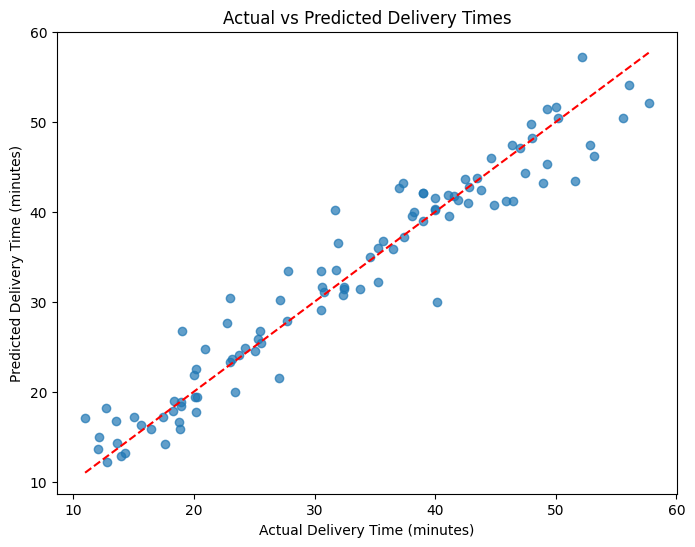

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Simulate sample data
np.random.seed(42)
n_samples = 500

# Features: distance (km), time of day (0-23 hours), traffic index (1-10 scale)
distance = np.random.uniform(0.5, 20.0, n_samples)  # distance in km
time_of_day = np.random.randint(0, 24, n_samples)     # hour of the day
traffic_index = np.random.randint(1, 11, n_samples)     # traffic condition, 1 (low) to 10 (high)

# Assume a base time with additional time added for distance, rush hour, and high traffic
# Base delivery time is 10 minutes, plus 2 minutes per km,
# plus 5 extra minutes during rush hours (7-9 and 17-19),
# plus 1 extra minute per traffic level above 5.
rush_hour = ((time_of_day >= 7) & (time_of_day <= 9)) | ((time_of_day >= 17) & (time_of_day <= 19))
delivery_time = (10 + distance * 2 +
                 np.where(rush_hour, 5, 0) +
                 np.maximum(traffic_index - 5, 0))

# Add some noise to simulate real-world conditions
delivery_time += np.random.normal(0, 3, n_samples)

# Create a DataFrame
df = pd.DataFrame({
    'distance': distance,
    'time_of_day': time_of_day,
    'traffic_index': traffic_index,
    'delivery_time': delivery_time
})

print("First five rows of the simulated dataset:")
print(df.head())

# Define features and target
X = df[['distance', 'time_of_day', 'traffic_index']]
y = df['delivery_time']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nMean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Plotting actual vs predicted delivery times
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Delivery Time (minutes)")
plt.ylabel("Predicted Delivery Time (minutes)")
plt.title("Actual vs Predicted Delivery Times")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()


Todo list
- költségkalkuláció kiszállítási módokhoz
- drónos kiszállítás költségkalkuláció
- drónos kiszállítás időkalkuláció
- nagy adathalmaz legenerálása
- modell alkotás
- előrejelző szkript megírása